In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
import sklearn
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shap
import requests

shap.initjs()

print(xgb.__version__)
print(sklearn.__version__)

2.1.3
1.5.2


# Получение данных

In [3]:
url = 'https://storage.yandexcloud.net/academy.ai/practica/parkinsons.data'
response = requests.get(url)

with open('data/parkinsons.data', 'w') as f:
    f.write(response.text)

In [4]:
df = pd.read_csv('data/parkinsons.data')
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

# Предобработка

In [6]:
# Деление на фичи и лейблы
X = df.iloc[:,(df.keys() != 'name') & (df.keys() != 'status')]
y = df['status']

In [7]:
y.value_counts()

status
1    147
0     48
Name: count, dtype: int64

In [8]:
# Нормализация
normalizer = Normalizer()
X = normalizer.fit_transform(X=X)

# Деление на тест-трейн

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8)

In [10]:
y_test.value_counts()

status
1    30
0     9
Name: count, dtype: int64

# Подбор гиперпараметров

In [11]:
X_train_hp, X_val_hp, y_train_hp, y_test_hp = train_test_split(X_train,y_train)

In [12]:
hyperparametres_for_tree = {
    'n_estimators': np.arange(5,100,10)
    ,'max_depth': np.arange(5,100,10)
    ,'max_leaves': np.arange(0,20,1)
    ,'learning_rate': np.linspace(0,1,20)
    ,'grow_policy': ['depthwise', 'lossguide']
    # ,'min_split_loss': np.linspace(0,100,20)
    ,'lambda': np.linspace(0,5,20)
    ,'alpha': np.linspace(0,5,20)

    ,'early_stopping_rounds': [2]
    ,'scale_pos_weight': [48/147]
}

clf = xgb.XGBClassifier()
random_search = RandomizedSearchCV(clf, param_distributions=hyperparametres_for_tree, n_iter=100, cv=5)
random_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
                                        'max_depth': array([ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95]),
                                        'max_leaves': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]),
                                        'n_estimators': array([ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95]),
                                        'scale_pos_weight': [0.32653061224489793]})

In [13]:
print(random_search.best_score_)
random_search.best_params_

0.8973790322580646


{'scale_pos_weight': 0.32653061224489793,
 'n_estimators': np.int64(25),
 'max_leaves': np.int64(5),
 'max_depth': np.int64(5),
 'learning_rate': np.float64(0.894736842105263),
 'lambda': np.float64(3.9473684210526314),
 'grow_policy': 'depthwise',
 'early_stopping_rounds': 2,
 'alpha': np.float64(0.0)}

# Обучение модели

In [14]:
clf = xgb.XGBClassifier(**random_search.best_params_)

In [15]:
clf.fit(X_train,y_train,eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.44018
[1]	validation_0-logloss:0.40651
[2]	validation_0-logloss:0.32739
[3]	validation_0-logloss:0.31868
[4]	validation_0-logloss:0.29649
[5]	validation_0-logloss:0.28867
[6]	validation_0-logloss:0.28107
[7]	validation_0-logloss:0.26781
[8]	validation_0-logloss:0.26898
[9]	validation_0-logloss:0.26181
[10]	validation_0-logloss:0.25759
[11]	validation_0-logloss:0.26168
[12]	validation_0-logloss:0.25594
[13]	validation_0-logloss:0.26380


XGBClassifier(alpha=np.float64(0.0), base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=2,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy='depthwise', importance_type=None,
              interaction_constraints=None,
              lambda=np.float64(3.9473684210526314),
              learning_rate=np.float64(0.894736842105263), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=np.int64(5),
              max_leaves=np.int64(5), min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None,
              n_estimators=np.int64(25), n_jobs=None, ...)

# Проверка модели

In [16]:
y_pred = clf.predict(X_test)

In [17]:
print('Точность модели: %.3f' % accuracy_score(y_test,y_pred))

Точность модели: 0.872


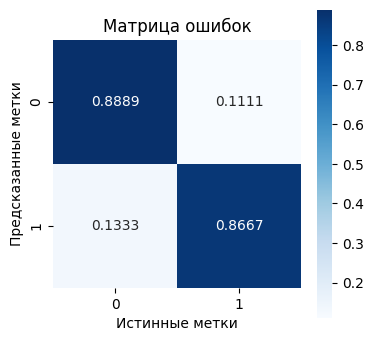

In [18]:
def show_confusion_matrix(y_true,y_pred):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    n = len(pd.unique(y_true))
    plt.figure(figsize=(n*2,n*2))
    confusion_normalized = confusion_matrix(y_true,y_pred,normalize='true')
    axis_labels = sorted(np.unique(y_test))
    ax = sns.heatmap(
        confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='.4f', square=True)
    plt.title("Матрица ошибок")
    plt.xlabel("Истинные метки")
    plt.ylabel("Предсказанные метки")

show_confusion_matrix(y_test,y_pred)

# Визуализация значимости фичей по SHAP

In [40]:
X_shap = pd.DataFrame(X_train,columns=normalizer.feature_names_in_)
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_shap)

## Топ влияния фичей

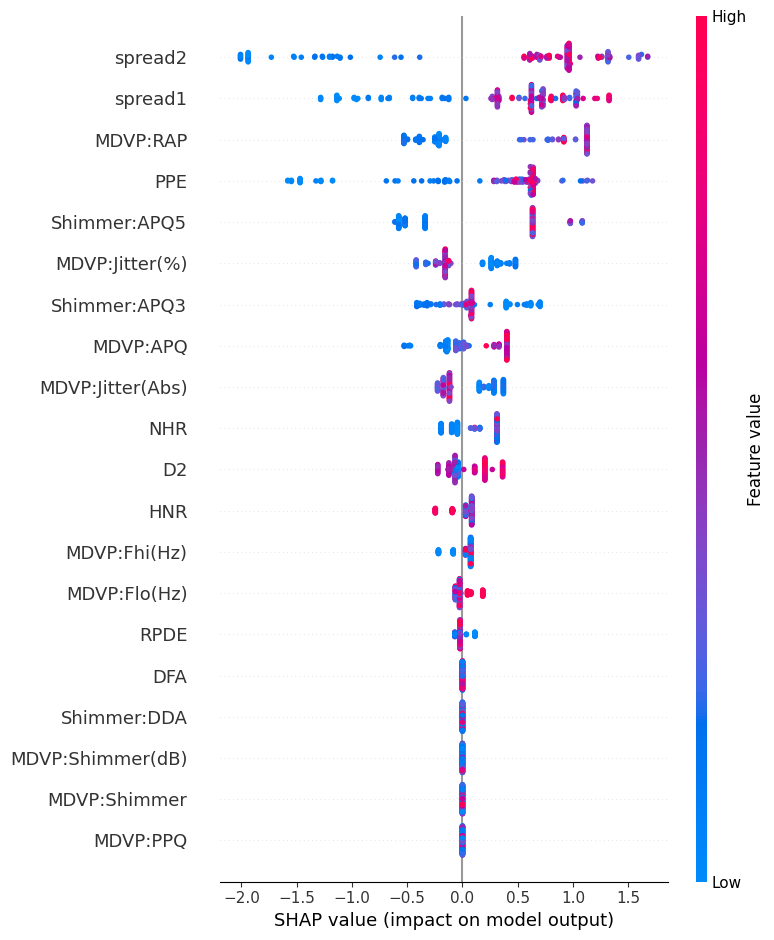

In [ ]:
shap.summary_plot(shap_values, X_shap, max_display=20)

Видно, что нелинейные показатели изменения основной частоты, они же spread1, spread2 и PPE вносят наибольший вклад в вывод. Причем довольно отнозначно: выше значение - выше вероятность паркинсона.
Что показывает, что эти самые нелинейные показатели довольно хорошо спроектированы. Возможно, даже, специально для болезни паркинсона.

Так же неплохо себя показывает один из линейных показателей: MDVP:RAP.

## Влияние фичей на несколько первых случаев

In [ ]:
shap.plots.force(shap_values[0,:])

In [42]:
shap.plots.force(shap_values[1,:])

# Создание и сохранение пайплайна

In [19]:
pipline = Pipeline([
    ('normilize', normalizer)
    ,('classify', clf)
])

In [20]:
with open('model.pkl','wb') as f:
    pickle.dump(pipline,f)